## Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
import xgboost as xgb

import pickle

from tensorflow.keras.layers import Conv1D, MaxPooling1D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout
from keras.regularizers import l2
from keras.layers import BatchNormalization, Dropout, Dense
from keras.models import Sequential

# Carga de datos

In [2]:
# Definir un diccionario 'files' que asocia el nombre del archivo CSV con la marca correspondiente
files = {"audi.csv": 'audi', "bmw.csv": 'bmw', "ford.csv": 'ford', "hyundi.csv": "hyundi", "merc.csv": "merc",         
         "skoda.csv": "skoda", "toyota.csv": "toyota", "vauxhall.csv": "vauxhall",  "vw.csv": "volkwagen"}

dfs = []

# Iterar sobre los elementos del diccionario 'files' que contiene el nombre del archivo y la marca
for f, m in files.items():

    df = pd.read_csv(f)
    # Renombramos la columna tax
    df = df.rename(columns={'tax(£)': 'tax'})

    # Agregar una nueva columna 'mark' con el nombre de la marca
    df['mark'] = m
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
df = pd.concat(dfs, ignore_index=True)

# Reorganizar las columnas poniendo 'mark' al principio
df = df[['mark'] + [col for col in df.columns if col != 'mark']]

df.to_csv('cars_concat.csv', index=False)
df.head(10)

,mark,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,audi,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,audi,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,audi,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
5,audi,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4
6,audi,A6,2016,13250,Automatic,76788,Diesel,30,61.4,2.0
7,audi,A4,2016,11750,Manual,75185,Diesel,20,70.6,2.0
8,audi,A3,2015,10200,Manual,46112,Petrol,20,60.1,1.4
9,audi,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4


In [3]:
# Cargamos el df con los tipos de carroceria
df_cars = pd.read_csv('mark_model_type.csv')
df_cars.head(10)

,mark,model,type
0,audi,A1,Hatchback
1,audi,A6,Sedán
2,audi,A4,Sedán
3,audi,A3,Hatchback
4,audi,Q3,SUV
5,audi,Q5,SUV
6,audi,A5,Coupe
7,audi,S4,Sedán
8,audi,Q2,SUV
9,audi,A7,Sedán


# Limpieza y análisis exploratorio de datos (EDA)

In [4]:
# Quitamos los espacios en blanco antes y después de cada modelo
df["model"] = df["model"].apply(lambda x : x.strip())

In [5]:
# Unimos ambos dataframes y obtenemos una nueva columna llamada "type"
df = pd.merge(left = df,
            right = df_cars[["model", "type"]],
             on = "model",
            how = "inner")

df.head(10)

,mark,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,type
0,audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Hatchback
1,audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Hatchback
2,audi,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4,Hatchback
3,audi,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4,Hatchback
4,audi,A1,2018,15800,Manual,10793,Petrol,145,56.5,1.4,Hatchback
5,audi,A1,2015,9500,Automatic,54754,Diesel,0,76.3,1.6,Hatchback
6,audi,A1,2017,10800,Manual,31447,Petrol,145,67.3,1.0,Hatchback
7,audi,A1,2014,11000,Manual,34315,Petrol,125,53.3,1.4,Hatchback
8,audi,A1,2013,7000,Manual,76269,Diesel,0,74.3,1.6,Hatchback
9,audi,A1,2017,11700,Manual,19268,Petrol,150,67.3,1.0,Hatchback


In [6]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mark          99187 non-null  object 
 1   model         99187 non-null  object 
 2   year          99187 non-null  int64  
 3   price         99187 non-null  int64  
 4   transmission  99187 non-null  object 
 5   mileage       99187 non-null  int64  
 6   fuelType      99187 non-null  object 
 7   tax           99187 non-null  int64  
 8   mpg           99187 non-null  float64
 9   engineSize    99187 non-null  float64
 10  type          99187 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.3+ MB


In [8]:
# Corregimos los nombres de las marcas
mapeo = {
    'audi': 'Audi',
    'bmw': 'BMW',
    'ford': 'Ford',
    'hyundi': 'Hyundai',
    'merc': 'Mercedes',
    'skoda': 'Skoda',
    'toyota': 'Toyota',
    'vauxhall': 'Vauxhall',
    'vw': 'Volkswagen'
}

# Aplica el mapeo a la columna "marca" del DataFrame
df['mark'] = df['mark'].replace(mapeo)

In [9]:
# Renombramos las columnas
df = df.rename(columns={'mark': 'brand', 'type': 'segment'})
df.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Hatchback
1,Audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Hatchback
2,Audi,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4,Hatchback
3,Audi,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4,Hatchback
4,Audi,A1,2018,15800,Manual,10793,Petrol,145,56.5,1.4,Hatchback


##### Descomentar pairplot si procede (30 segundos de ejecución y no se ven nada reseñable)

In [10]:
# sns.pairplot(df)

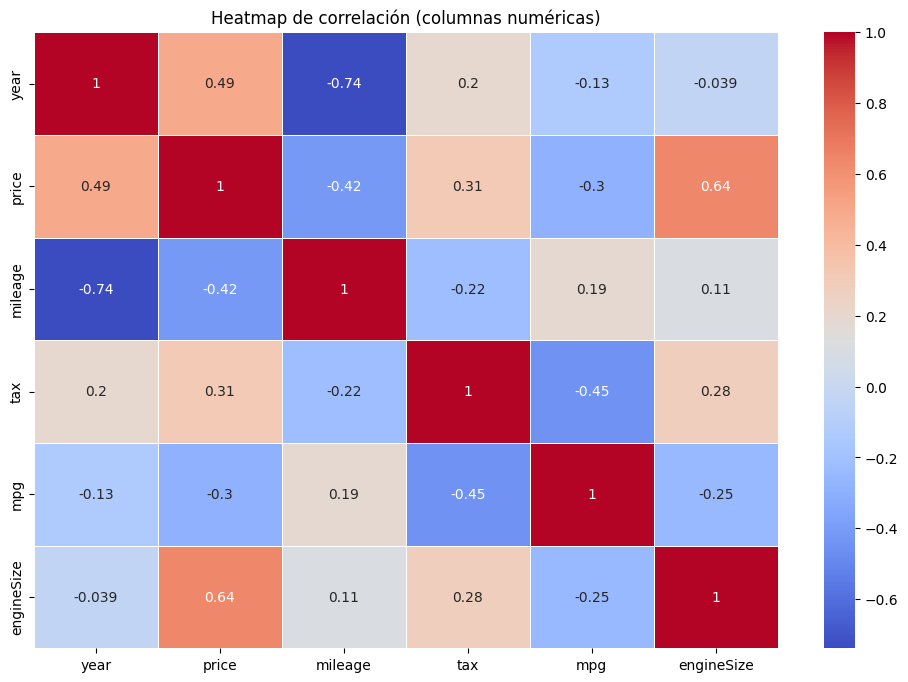

In [11]:
# Hacemos un heatmap para ver la correlación de las columnas númericas.
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

corr_matrix_numerica = df[columnas_numericas].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_numerica, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Heatmap de correlación (columnas numéricas)")
plt.show()

In [12]:
df['engineSize'].sort_values()

76110    0.0
41222    0.0
32181    0.0
41225    0.0
32182    0.0
        ... 
55767    6.2
53200    6.2
10455    6.3
13892    6.6
13896    6.6
Name: engineSize, Length: 99187, dtype: float64

In [13]:
cantidad_valores_cero = (df['engineSize'] == 0).sum()
print("Cantidad de valores 0 en 'engineSize':", cantidad_valores_cero)


Cantidad de valores 0 en 'engineSize': 273


In [14]:
# Borramos valores de cero en la columna "engineSize"
df = df[df['engineSize'] != 0]
df.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Hatchback
1,Audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Hatchback
2,Audi,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4,Hatchback
3,Audi,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4,Hatchback
4,Audi,A1,2018,15800,Manual,10793,Petrol,145,56.5,1.4,Hatchback


In [15]:
# Multiplica la columna 'engineSize' por 1000 y convierte a entero
df['engineSize']= (df['engineSize'] * 1000).astype(int)

In [16]:
# Revisamos los valores de la eficiencia "mpg"
df = df.sort_values(by='mpg', ascending=True)
df.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
98534,volkwagen,Golf SV,2019,17950,Manual,100,Petrol,145,0.3,1000,Hatchback
47414,Mercedes,A Class,2020,31500,Semi-Auto,1000,Hybrid,135,1.1,1300,Hatchback
43086,Hyundai,Ioniq,2019,22998,Automatic,2844,Hybrid,140,1.1,1600,Hatchback
43113,Hyundai,Ioniq,2020,23895,Automatic,4152,Hybrid,135,1.1,1600,Hatchback
43247,Hyundai,Ioniq,2020,26995,Automatic,1290,Hybrid,135,1.1,1600,Hatchback


In [17]:
# Filtra las filas donde el valor de 'mpg' no sea igual a 0.3
df = df[df['mpg'] != 0.3]
df.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
47414,Mercedes,A Class,2020,31500,Semi-Auto,1000,Hybrid,135,1.1,1300,Hatchback
43086,Hyundai,Ioniq,2019,22998,Automatic,2844,Hybrid,140,1.1,1600,Hatchback
43113,Hyundai,Ioniq,2020,23895,Automatic,4152,Hybrid,135,1.1,1600,Hatchback
43247,Hyundai,Ioniq,2020,26995,Automatic,1290,Hybrid,135,1.1,1600,Hatchback
43364,Hyundai,Ioniq,2020,28995,Automatic,5213,Hybrid,135,1.1,1600,Hatchback
...,...,...,...,...,...,...,...,...,...,...,...
19813,BMW,i3,2016,17000,Automatic,41063,Other,0,470.8,600,Hatchback
19812,BMW,i3,2017,19500,Automatic,23956,Other,135,470.8,600,Hatchback
19814,BMW,i3,2017,17600,Automatic,50867,Other,135,470.8,600,Hatchback
19811,BMW,i3,2017,20000,Automatic,19178,Other,0,470.8,600,Hatchback


In [18]:
df['fuelType'].unique()

array(['Hybrid', 'Diesel', 'Petrol', 'Other', 'Electric'], dtype=object)

In [19]:
filas_filtradas = df[(df['fuelType'] == 'Other')]
filas_filtradas

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
97881,volkwagen,Touareg,2019,44495,Automatic,385,Other,145,25.5,3000,SUV
97882,volkwagen,Touareg,2019,47995,Automatic,5305,Other,145,25.5,3000,SUV
95888,volkwagen,Tiguan,2019,29995,Automatic,4229,Other,145,30.4,2000,SUV
95879,volkwagen,Tiguan,2019,43995,Automatic,2927,Other,150,30.4,2000,SUV
95842,volkwagen,Tiguan,2019,32249,Automatic,5000,Other,145,31.4,2000,SUV
...,...,...,...,...,...,...,...,...,...,...,...
19813,BMW,i3,2016,17000,Automatic,41063,Other,0,470.8,600,Hatchback
19812,BMW,i3,2017,19500,Automatic,23956,Other,135,470.8,600,Hatchback
19814,BMW,i3,2017,17600,Automatic,50867,Other,135,470.8,600,Hatchback
19811,BMW,i3,2017,20000,Automatic,19178,Other,0,470.8,600,Hatchback


In [20]:
filas_filtradas['model'].unique()

array(['Touareg', 'Tiguan', 'T-Roc', 'Sharan', 'Supra', 'Golf', 'Touran',
       'Passat', 'Polo', 'Kamiq', 'Verso', 'Yaris', 'RAV4', 'Arteon',
       'T-Cross', 'Yeti', 'Up', 'Corolla', 'C-HR', 'Aygo', 'Fabia',
       'Prius', 'Viva', 'Mondeo', 'GLE Class', 'Auris', 'Ioniq', 'X5',
       '3 Series', 'C Class', 'i8', '2 Series', '5 Series', 'i3'],
      dtype=object)

In [21]:
df = df.sort_values(by='mileage', ascending=False)
df.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
2030,Audi,A6,2008,2490,Manual,323000,Diesel,200,44.1,2000,Sedán
58827,Skoda,Octavia,2010,1190,Manual,300000,Diesel,125,57.6,1900,Sedán
81217,Vauxhall,Zafira,2013,1395,Manual,279000,Diesel,150,55.4,1700,Minivan
56580,Mercedes,V Class,2010,6949,Automatic,259000,Diesel,540,30.7,3000,Minivan
58666,Skoda,Octavia,2010,1485,Manual,250650,Diesel,125,57.6,1900,Sedán


In [22]:
filas_filtradas = df[(df['transmission'] == 'Other')]
filas_filtradas

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
44362,Mercedes,SLK,2015,12995,Other,39000,Diesel,150,56.5,2100,Convertible
43358,Hyundai,Ioniq,2017,12495,Other,27779,Hybrid,0,78.5,1600,Hatchback
41186,Hyundai,Tucson,2017,16995,Other,25915,Petrol,145,39.8,1600,SUV
66118,Toyota,Yaris,2015,12795,Other,16733,Hybrid,0,78.0,1500,Hatchback
77820,Vauxhall,Mokka,2019,22499,Other,4500,Petrol,145,42.2,1500,SUV
63496,Skoda,Scala,2019,15999,Other,3500,Petrol,145,47.1,1000,Hatchback
77717,Vauxhall,Mokka,2019,13499,Other,3000,Petrol,145,44.8,1400,SUV
77102,Vauxhall,Mokka,2019,19995,Other,1450,Diesel,145,57.7,1500,SUV


In [23]:
# Borramos "otras" transmisiones.
df = df[df['transmission'] != 'Other']

In [24]:
df = df.sort_values(by='year', ascending=False)
df

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
27921,Ford,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1400,Hatchback
54007,Mercedes,C Class,2020,35999,Automatic,500,Diesel,145,55.4,2000,Sedán
68771,Toyota,Aygo,2020,10740,Manual,500,Petrol,145,57.7,1000,Hatchback
47321,Mercedes,A Class,2020,44995,Semi-Auto,500,Petrol,145,32.8,2000,Hatchback
20302,BMW,X1,2020,34999,Semi-Auto,3000,Diesel,150,52.3,2000,SUV
...,...,...,...,...,...,...,...,...,...,...,...
10454,Audi,A8,1997,4650,Automatic,122000,Petrol,265,18.9,4200,Sedán
44793,Mercedes,SL CLASS,1997,9995,Automatic,76000,Petrol,255,28.2,3200,Convertible
39412,Ford,Escort,1996,3000,Manual,50000,Petrol,265,34.4,1800,Hatchback
11600,BMW,5 Series,1996,5995,Automatic,36000,Petrol,270,26.4,2800,Sedán


In [25]:
# filtramos años atípicos (habiendo explorado externamente los modelos de coche) y corregimos errores
df = df[df['year'] >= 1995]
df.loc[df['year'] == 2060, 'year'] = 2006

In [26]:
# Borramos duplicados
df = df.drop_duplicates()
df.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,segment
27921,Ford,Fiesta,2006,6495,Automatic,54807,Petrol,205,42.8,1400,Hatchback
54007,Mercedes,C Class,2020,35999,Automatic,500,Diesel,145,55.4,2000,Sedán
68771,Toyota,Aygo,2020,10740,Manual,500,Petrol,145,57.7,1000,Hatchback
47321,Mercedes,A Class,2020,44995,Semi-Auto,500,Petrol,145,32.8,2000,Hatchback
20302,BMW,X1,2020,34999,Semi-Auto,3000,Diesel,150,52.3,2000,SUV


In [27]:
# Asignamos esta variable para poder graficar después del get_dummies
conteo_modelos = df.groupby(['brand', 'segment'])['model'].nunique().reset_index()

In [28]:
df = pd.get_dummies(df, columns=['transmission', 'fuelType', 'segment', 'brand'])
df

,model,year,price,mileage,tax,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,...,segment_Sedán,brand_Audi,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Skoda,brand_Toyota,brand_Vauxhall,brand_volkwagen
27921,Fiesta,2006,6495,54807,205,42.8,1400,True,False,False,...,False,False,False,True,False,False,False,False,False,False
54007,C Class,2020,35999,500,145,55.4,2000,True,False,False,...,True,False,False,False,False,True,False,False,False,False
68771,Aygo,2020,10740,500,145,57.7,1000,False,True,False,...,False,False,False,False,False,False,False,True,False,False
47321,A Class,2020,44995,500,145,32.8,2000,False,False,True,...,False,False,False,False,False,True,False,False,False,False
20302,X1,2020,34999,3000,150,52.3,2000,False,False,True,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76255,Astra,1997,950,89233,265,35.8,1600,False,True,False,...,False,False,False,False,False,False,False,False,True,False
10454,A8,1997,4650,122000,265,18.9,4200,True,False,False,...,True,True,False,False,False,False,False,False,False,False
44793,SL CLASS,1997,9995,76000,255,28.2,3200,True,False,False,...,False,False,False,False,False,True,False,False,False,False
39412,Escort,1996,3000,50000,265,34.4,1800,False,True,False,...,False,False,False,True,False,False,False,False,False,False


In [29]:
# Renombramos las columnas después del get dummies

# Crear una lista para almacenar los nuevos nombres de columnas
new_column_names = []

# Iterar a través de los nombres de las columnas existentes
for column_name in df.columns:
    # Dividir el nombre de la columna por guiones y obtener la segunda palabra
    split_name = column_name.split('_')
    if len(split_name) >= 2:
        new_column_name = split_name[1]
        new_column_names.append(new_column_name)
    else:
        new_column_names.append(column_name)

# Asignar los nuevos nombres de columnas al DataFrame
df.columns = new_column_names

### EDA

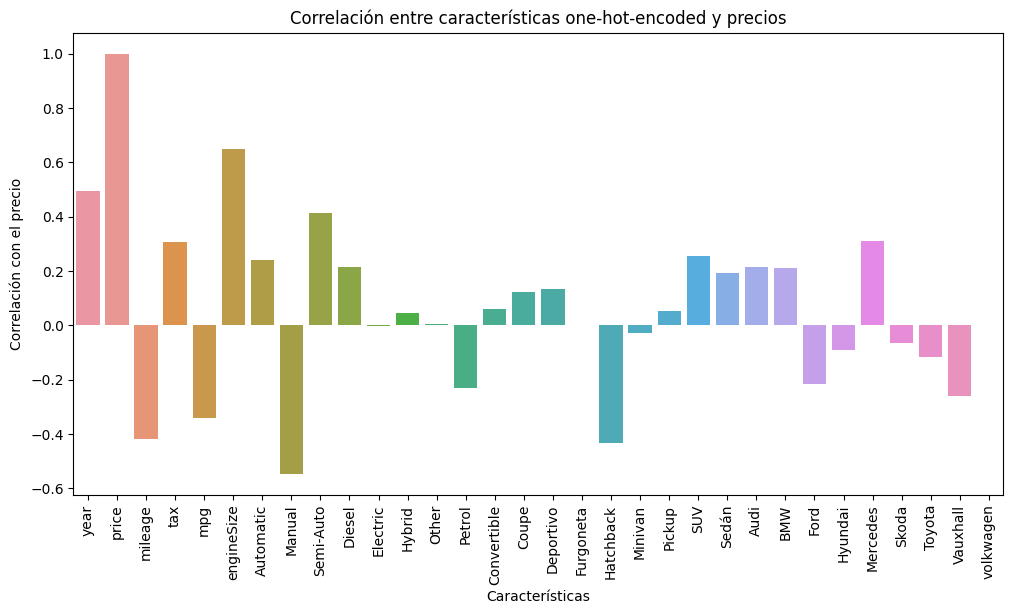

In [30]:
df1 = df.drop('model', axis=1)

# Calcula la matriz de correlación
corr_matrix = df1.corr()

# Filtra la correlación con la columna 'price'
price_corr = corr_matrix['price']

# Plotea la correlación
plt.figure(figsize=(12, 6))
sns.barplot(x=price_corr.index, y=price_corr.values)
plt.xticks(rotation=90)
plt.title("Correlación entre características one-hot-encoded y precios")
plt.xlabel("Características")
plt.ylabel("Correlación con el precio")
plt.show()

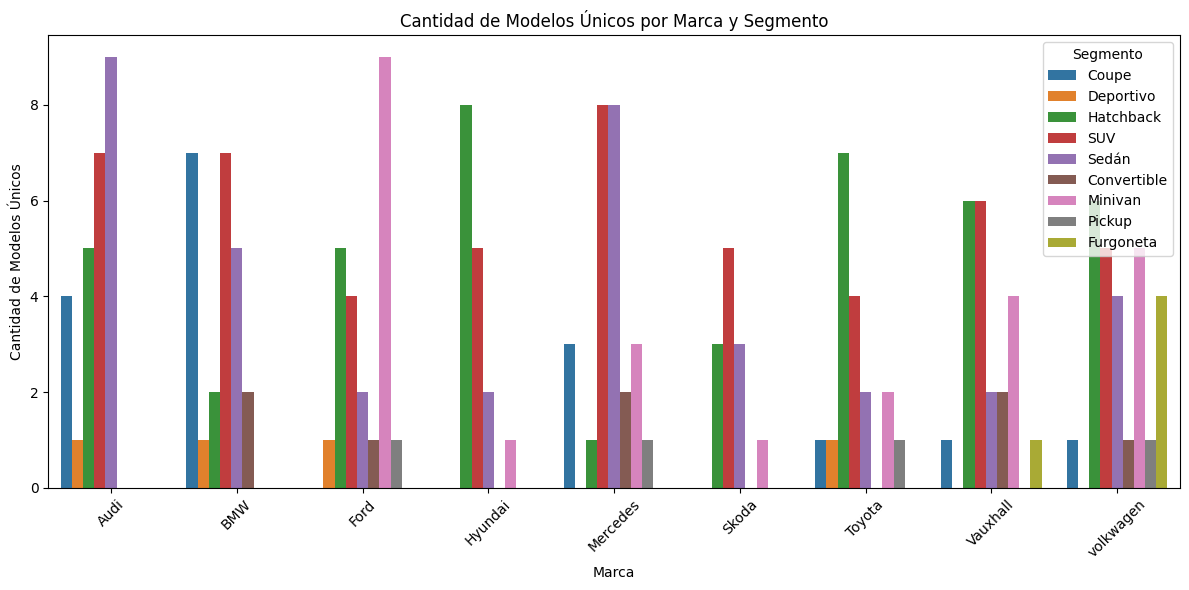

In [31]:
# Crea un gráfico de barras para mostrar el conteo de modelos GRAFICO DE LA VARIABLE CONTEO_MODELOS
plt.figure(figsize=(12, 6))
sns.barplot(data=conteo_modelos, x='brand', y='model', hue='segment')
plt.xlabel('Marca')
plt.ylabel('Cantidad de Modelos Únicos')
plt.title('Cantidad de Modelos Únicos por Marca y Segmento')
plt.xticks(rotation=45)
plt.legend(title='Segmento')
plt.tight_layout()
plt.show()

In [32]:
df.columns

Index(['model', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'Automatic', 'Manual', 'Semi-Auto', 'Diesel', 'Electric', 'Hybrid',
       'Other', 'Petrol', 'Convertible', 'Coupe', 'Deportivo', 'Furgoneta',
       'Hatchback', 'Minivan', 'Pickup', 'SUV', 'Sedán', 'Audi', 'BMW', 'Ford',
       'Hyundai', 'Mercedes', 'Skoda', 'Toyota', 'Vauxhall', 'volkwagen'],
      dtype='object')

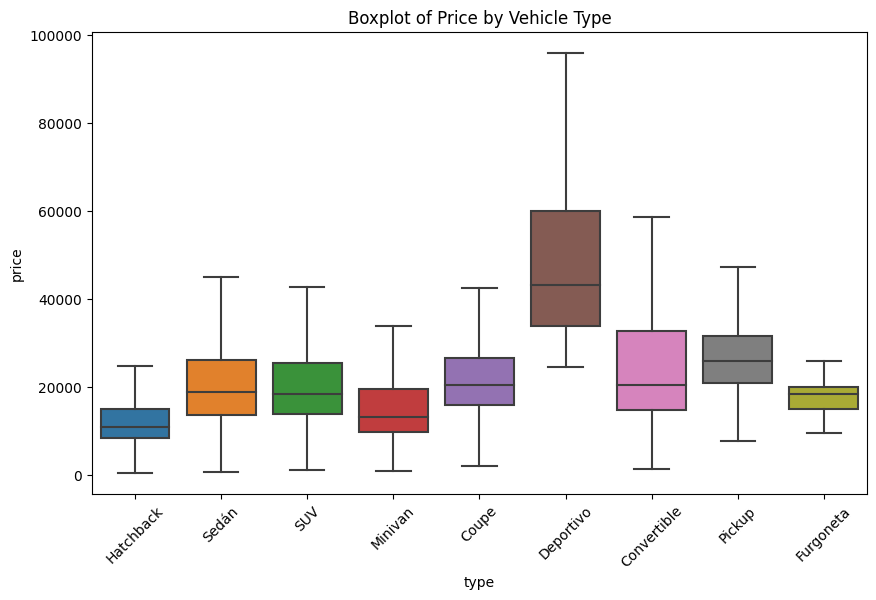

In [33]:
types = ['Convertible', 'Coupe', 'Deportivo', 'Furgoneta', 'Hatchback',
       'Minivan', 'Pickup', 'SUV', 'Sedán']

# Preparando los datos
data = df[df[types].eq(1).any(axis=1)]
data['type'] = data[types].idxmax(1)

plt.figure(figsize=(10,6))
sns.boxplot(x='type', y='price', data=data, showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot de precio por carroceria')
plt.show()


C:\Users\Jorge\AppData\Local\Temp\ipykernel_14712\2276231072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fuelType'] = data[fuelTypes].idxmax(1)


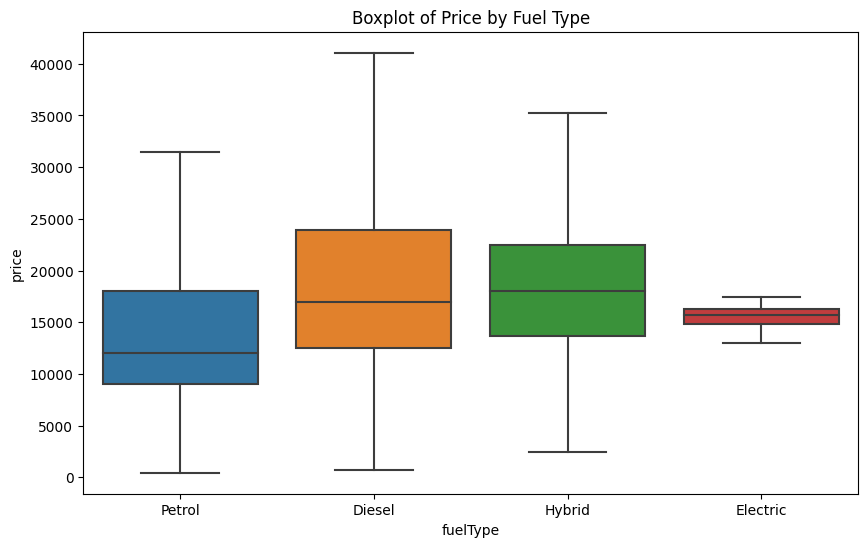

In [34]:
fuelTypes = ['Diesel', 'Electric', 'Hybrid', 'Petrol']

data = df[df[fuelTypes].eq(1).any(axis=1)]
data['fuelType'] = data[fuelTypes].idxmax(1)

plt.figure(figsize=(10,6))
sns.boxplot(x='fuelType', y='price', data=data, showfliers=False)
plt.title('Boxplot de precio por tipo de combustible')
plt.show()


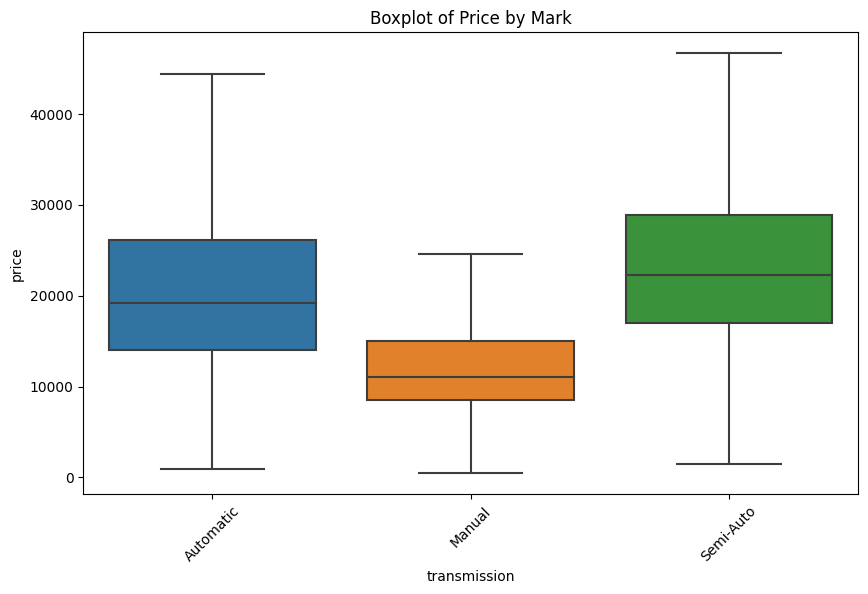

In [35]:
transmission = ['Automatic', 'Manual','Semi-Auto']

data = df[df[transmission].eq(1).any(axis=1)]
data['transmission'] = data[transmission].idxmax(1)

plt.figure(figsize=(10,6))
sns.boxplot(x='transmission', y='price', data=data, showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot de precio por transmisión')
plt.show()


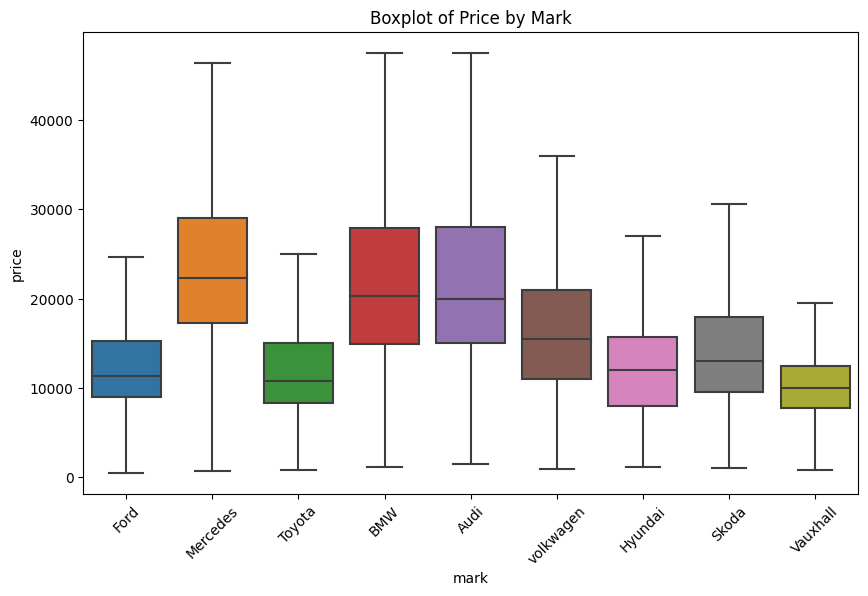

In [36]:
marks = ['Audi', 'BMW', 'Ford', 'Hyundai',
       'Mercedes', 'Skoda', 'Toyota', 'Vauxhall', 'volkwagen']

data = df[df[marks].eq(1).any(axis=1)]
data['mark'] = data[marks].idxmax(1)

plt.figure(figsize=(10,6))
sns.boxplot(x='mark', y='price', data=data, showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot de precio por marca')
plt.show()

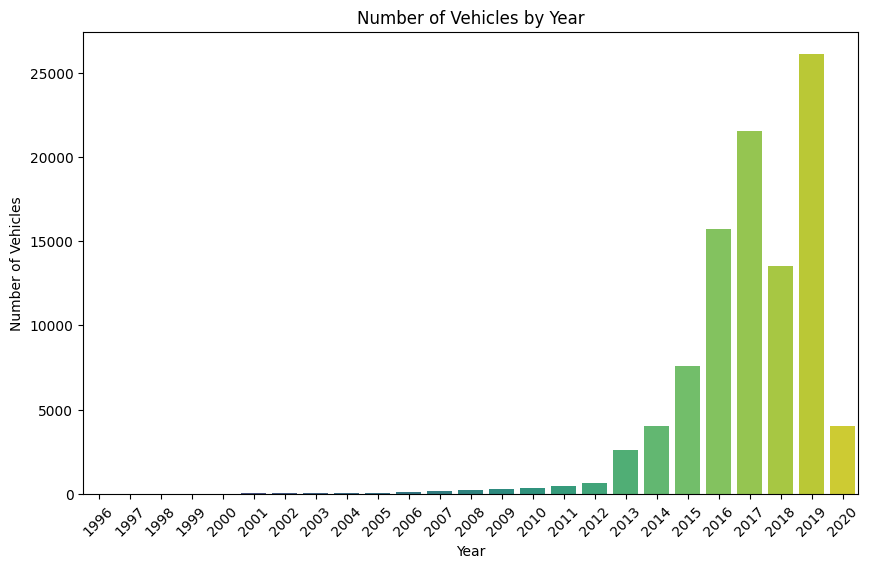

In [37]:
count_by_year = df['year'].value_counts().reset_index()
count_by_year.columns = ['year', 'count']

count_by_year = count_by_year.sort_values('year')

plt.figure(figsize=(10,6))
sns.barplot(x='year', y='count', data=count_by_year, palette='viridis')
plt.xticks(rotation=45)
plt.title('Número de vehículos por año')
plt.ylabel('Numero de vehículos')
plt.xlabel('Año')
plt.show()

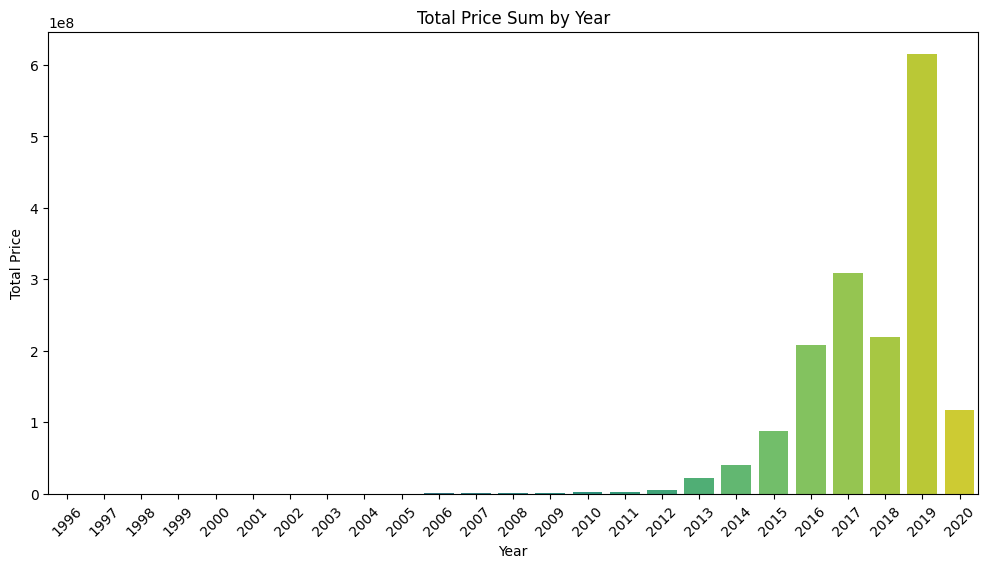

In [38]:
# Suma de precios por agrupacion por el año.
sum_prices_by_year = df.groupby('year')['price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='year', y='price', data=sum_prices_by_year, palette="viridis")
plt.title('Suma total de precio por año')
plt.ylabel('Precio total')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.show()

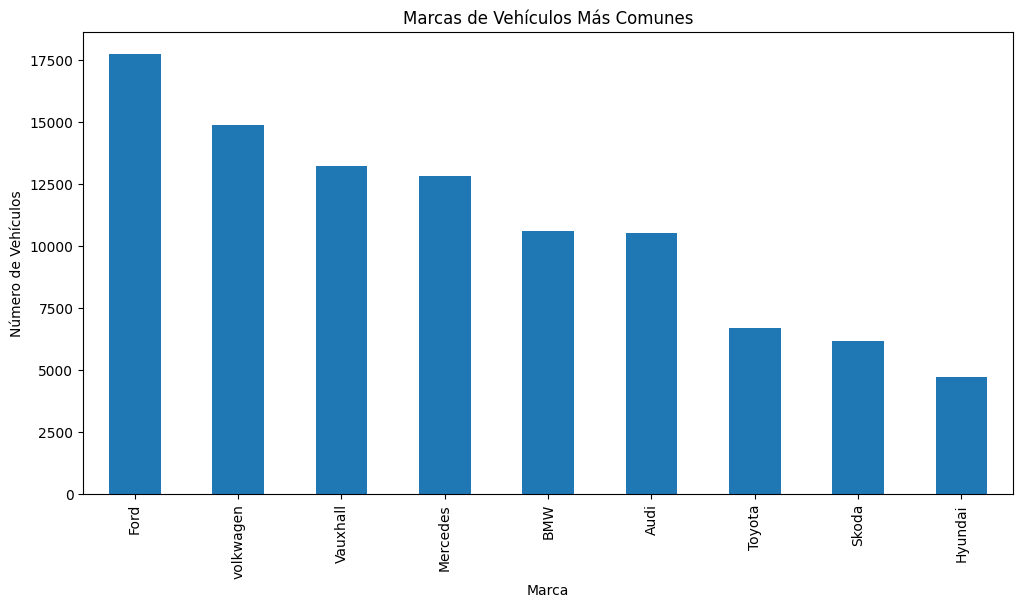

In [39]:
# Lista de marcas deseadas
marcas_deseadas = ['Audi', 'BMW', 'Ford', 'Hyundai',
                    'Mercedes', 'Skoda', 'Toyota', 'Vauxhall', 'volkwagen']

df_filtrado = df[marcas_deseadas]

# Realizar el conteo de las marcas en el DataFrame filtrado
marca_counts = df_filtrado.sum()  

# Gráfico de barras de las marcas más comunes
plt.figure(figsize=(12, 6))
marca_counts.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Marca')
plt.ylabel('Número de Vehículos')
plt.title('Marcas de Vehículos Más Comunes')
plt.xticks(rotation=45)
plt.show()


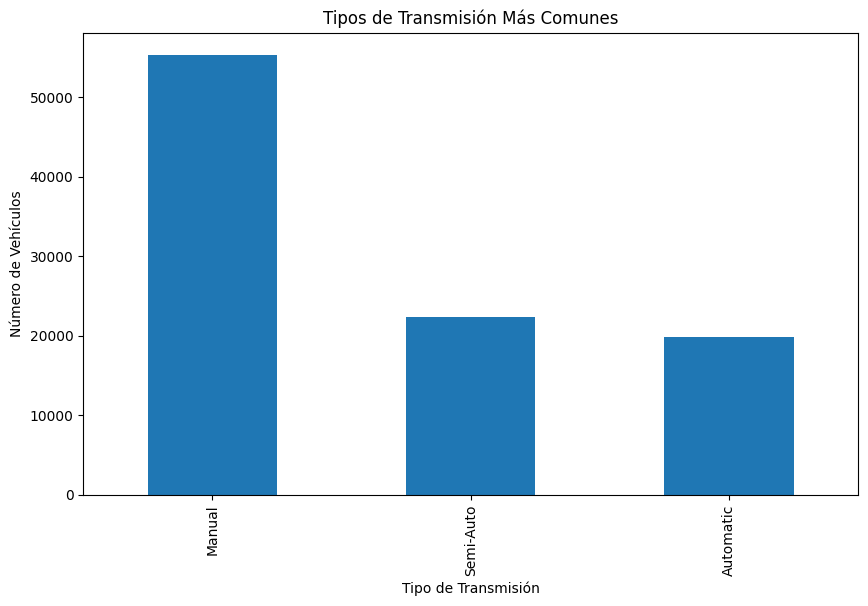

In [40]:
# Lista de tipos de transmisión deseados
tipos_transmision = ['Automatic', 'Manual', 'Semi-Auto']

# Filtrar el DataFrame para incluir solo las columnas de los tipos de transmisión deseados
df_filtrado = df[tipos_transmision]

# Realizar el conteo de los tipos de transmisión en el DataFrame filtrado
transmision_counts = df_filtrado.sum()

# Gráfico de barras de los tipos de transmisión más comunes
plt.figure(figsize=(10, 6))
transmision_counts.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Tipo de transmisión')
plt.ylabel('Número de vehículos')
plt.title('Tipos de transmisión más comunes')
plt.xticks(rotation=45)
plt.show()


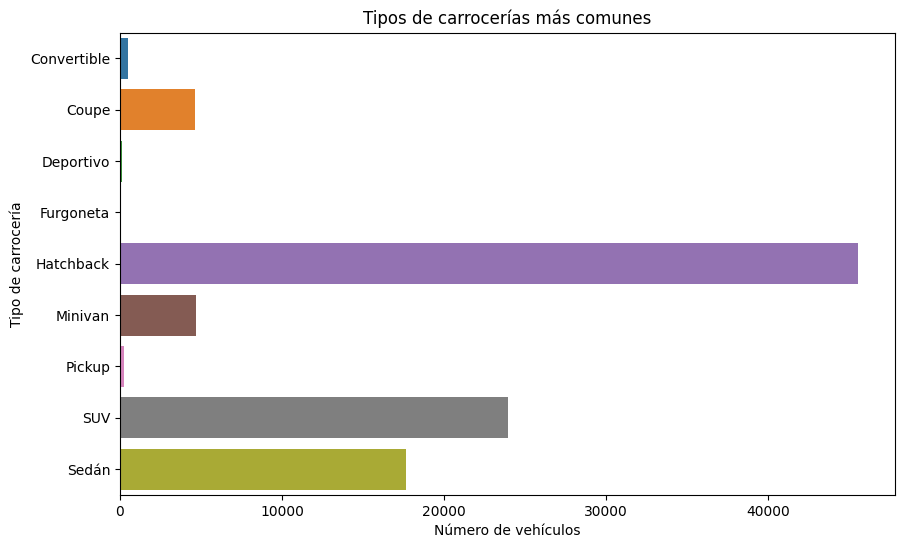

In [41]:
# Lista de tipos de transmisión deseados
tipos_de_carrocerias = ['Convertible', 'Coupe', 'Deportivo', 
                    'Furgoneta', 'Hatchback', 'Minivan', 
                    'Pickup', 'SUV', 'Sedán']

# Filtrar el DataFrame para incluir solo las columnas de los tipos de transmisión deseados
df_filtrado = df[tipos_de_carrocerias]

# Realizar el conteo de los tipos de transmisión en el DataFrame filtrado
segment_counts = df_filtrado.sum()  

# Gráfico de barras de los tipos de transmisión más comunes
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.values, y=segment_counts.index, orient='h')
plt.xlabel('Número de vehículos')
plt.ylabel('Tipo de carrocería')
plt.title('Tipos de carrocerías más comunes')
plt.show()


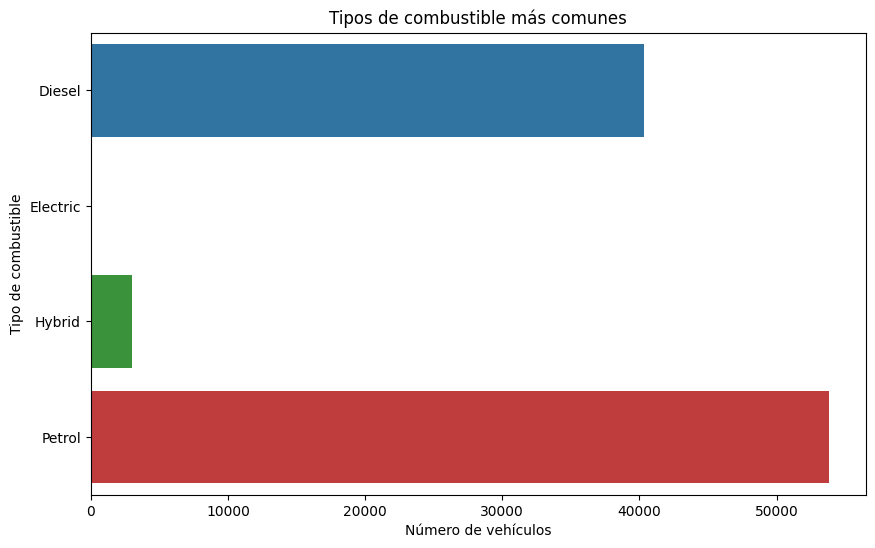

In [42]:
# Lista de tipos de transmisión deseados
tipos_de_combustible = ['Diesel', 'Electric', 'Hybrid', 'Petrol']

# Filtrar el DataFrame para incluir solo las columnas de los tipos de transmisión deseados
df_filtrado = df[tipos_de_combustible]

# Realizar el conteo de los tipos de transmisión en el DataFrame filtrado
fuel_counts = df_filtrado.sum()  

# Gráfico de barras de los tipos de transmisión más comunes
plt.figure(figsize=(10, 6))
sns.barplot(x=fuel_counts.values, y=fuel_counts.index, orient='h')
plt.xlabel('Número de vehículos')
plt.ylabel('Tipo de combustible')
plt.title('Tipos de combustible más comunes')
plt.show()

In [43]:
df['Electric'].value_counts()

Electric
False    97430
True         4
Name: count, dtype: int64

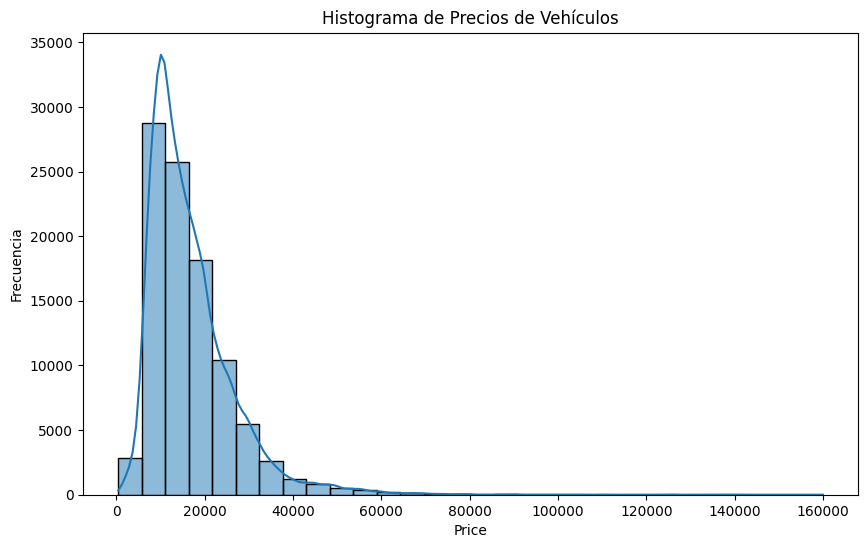

In [44]:
# Histograma del precio
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', bins=30, kde=True)
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios de Vehículos')
plt.show()


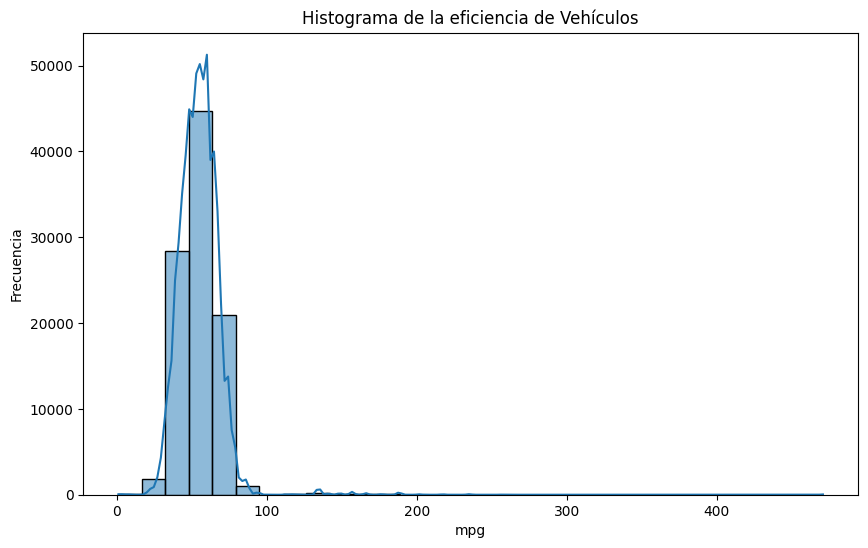

In [45]:
# Histograma de la eficiencia
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='mpg', bins=30, kde=True)
plt.xlabel('mpg')
plt.ylabel('Frecuencia')
plt.title('Histograma de la eficiencia de Vehículos')
plt.show()


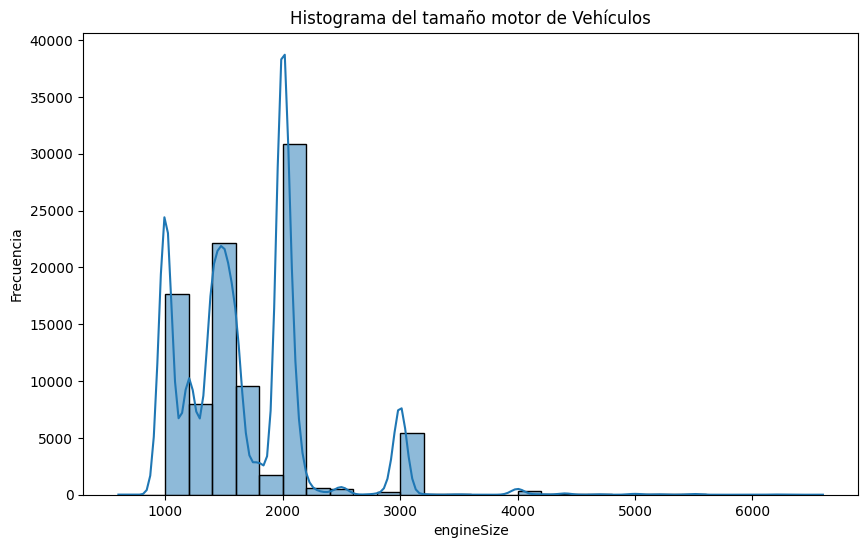

In [46]:
# Histograma del tamaño motor
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='engineSize', bins=30, kde=True)
plt.xlabel('engineSize')
plt.ylabel('Frecuencia')
plt.title('Histograma del tamaño motor de vehículos')
plt.show()


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97434 entries, 27921 to 11600
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   model        97434 non-null  object 
 1   year         97434 non-null  int64  
 2   price        97434 non-null  int64  
 3   mileage      97434 non-null  int64  
 4   tax          97434 non-null  int64  
 5   mpg          97434 non-null  float64
 6   engineSize   97434 non-null  int32  
 7   Automatic    97434 non-null  bool   
 8   Manual       97434 non-null  bool   
 9   Semi-Auto    97434 non-null  bool   
 10  Diesel       97434 non-null  bool   
 11  Electric     97434 non-null  bool   
 12  Hybrid       97434 non-null  bool   
 13  Other        97434 non-null  bool   
 14  Petrol       97434 non-null  bool   
 15  Convertible  97434 non-null  bool   
 16  Coupe        97434 non-null  bool   
 17  Deportivo    97434 non-null  bool   
 18  Furgoneta    97434 non-null  bool   
 19  Hatch

In [48]:
df.to_csv("csv_limpio.csv", index = False)

## Partición de datos.

#### Separamos los datos en 3. El 67% para entrenar y el resto para testear y para la validación con datos reales.

In [50]:
df.columns

Index(['model', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'Automatic', 'Manual', 'Semi-Auto', 'Diesel', 'Electric', 'Hybrid',
       'Other', 'Petrol', 'Convertible', 'Coupe', 'Deportivo', 'Furgoneta',
       'Hatchback', 'Minivan', 'Pickup', 'SUV', 'Sedán', 'Audi', 'BMW', 'Ford',
       'Hyundai', 'Mercedes', 'Skoda', 'Toyota', 'Vauxhall', 'volkwagen'],
      dtype='object')

In [51]:
# División del DataFrame en entrenamiento+prueba y validación
train_test_data, valid_data = train_test_split(df, test_size=0.15, random_state=42)

# División del conjunto de entrenamiento+prueba en entrenamiento y prueba
train_data, test_data = train_test_split(train_test_data, test_size=0.20, random_state=42)

# Separación de características y etiquetas para el conjunto de entrenamiento
X_train = train_data.drop(['price', 'model'], axis=1)
y_train = train_data['price']

# Separación de características y etiquetas para el conjunto de prueba
X_test = test_data.drop(['price', 'model'], axis=1)
y_test = test_data['price']

# Separación de características y etiquetas para el conjunto de validación
X_valid = valid_data.drop(['price', 'model'], axis=1)
y_valid = valid_data['price']

# Impresión de las dimensiones de cada conjunto
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Validation data shape: {X_valid.shape}")

Train data shape: (66254, 31)
Test data shape: (16564, 31)
Validation data shape: (14616, 31)


## Entrenamiento


In [52]:
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

# Función para evaluar un modelo    
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return r2, mse, rmse, mae

# Lista de modelos
modelos = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=1.0)),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forest Regressor', RandomForestRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor()),
    # ('Support Vector Regressor', SVR()),
    ('K-Neighbors Regressor', KNeighborsRegressor()),
    ('Neural Network Regressor', MLPRegressor()),
    ('XGBoost', XGBRegressor())
]

# Entrenar y evaluar cada modelo
for m, modelo in modelos:
    modelo.fit(X_train_standard, y_train)

# Evaluación de modelos y almacenamiento de resultados
results = {}
for nombre, modelo in modelos:
    r2, mse, rmse, mae = evaluate_model(modelo, X_test_standard, y_test)
    results[nombre] = {"R^2": r2, "MSE": mse, "RMSE": rmse, "MAE": mae}

# Creación del DataFrame con los resultados
df_results = pd.DataFrame(results).T

df_results

C:\Users\Jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573


In [53]:
df_results["RMSE"].sort_values()

Random Forest Regressor        2161.652710
XGBoost                        2231.854937
K-Neighbors Regressor          2604.149449
Decision Tree Regressor        2769.203763
Gradient Boosting Regressor    3106.239093
Neural Network Regressor       3353.771603
Linear Regression              4572.195259
Ridge Regression               4572.281318
Lasso Regression               4572.334024
Name: RMSE, dtype: float64

#### He codigo los 5 modelos con RMSE mas bajos y les he aplicado grid search. Todos por encima de 0.90 en R^2.
##### Al devolverme los valores óptimos los he recreado de nuevo mejorando ligeramente el resultado.

In [54]:
# # Definir el rango de valores para los hiperparámetros
# param_grid_xgb = {
#     'max_depth': [3, 6, 9],
#     'n_estimators': [100, 300, 500],
#     'learning_rate': [0.01, 0.1, 0.3],
# }
# # Crear un estimador XGBoost
# xgb_regressor = XGBRegressor()

# # Configurar la búsqueda de hiperparámetros con GridSearchCV
# grid_search_xgb = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid_xgb, 
#                                cv=3, n_jobs=-1, verbose=2, scoring='r2')

# # Realizar la búsqueda de hiperparámetros en los datos de entrenamiento
# grid_search_xgb.fit(X_train_standard, y_train)

# # Obtener los mejores hiperparámetros encontrados
# best_params_xgb = grid_search_xgb.best_params_

# print("Mejores parámetros para XGBoost:", best_params_xgb)


In [55]:
# Crear el estimador XGBoost con los mejores hiperparámetros
best_xgb_regressor = XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300)

# Entrenar el modelo XGBoost en el conjunto de entrenamiento
best_xgb_regressor.fit(X_train_standard, y_train)

# Predicciones en el conjunto de prueba
y_pred_xgb = best_xgb_regressor.predict(X_test_standard)

# Calcular métricas de evaluación en el conjunto de prueba
r2_test_xgb = r2_score(y_test, y_pred_xgb)
mse_test_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_test_xgb = np.sqrt(mse_test_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("R^2 en el conjunto de prueba (XGBoost):", r2_test_xgb)
print("MSE en el conjunto de prueba (XGBoost):", mse_test_xgb)
print("RMSE en el conjunto de prueba (XGBoost):", rmse_test_xgb)
print("MAE en el conjunto de prueba (XGBoost):", mae_test_xgb)

# Crear una nueva fila de resultados para XGBoost
new_row_xgb = pd.DataFrame({
    'R^2': [r2_test_xgb],
    'MSE': [mse_test_xgb],
    'RMSE': [rmse_test_xgb],
    'MAE': [mae_test_xgb]
}, index=['Optimized XGBoost'])

# Agregar la nueva fila al dataframe df_results
df_results = pd.concat([df_results, new_row_xgb])

# Mostrar el dataframe actualizado
df_results


R^2 en el conjunto de prueba (XGBoost): 0.9579340898696903
MSE en el conjunto de prueba (XGBoost): 4090045.7080769357
RMSE en el conjunto de prueba (XGBoost): 2022.3861421788213
MAE en el conjunto de prueba (XGBoost): 1213.3186624135926


,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573
Optimized XGBoost,0.957934,4.090046e+06,2022.386142,1213.318662


In [56]:
df_results["RMSE"].sort_values()

Optimized XGBoost              2022.386142
Random Forest Regressor        2161.652710
XGBoost                        2231.854937
K-Neighbors Regressor          2604.149449
Decision Tree Regressor        2769.203763
Gradient Boosting Regressor    3106.239093
Neural Network Regressor       3353.771603
Linear Regression              4572.195259
Ridge Regression               4572.281318
Lasso Regression               4572.334024
Name: RMSE, dtype: float64

In [57]:
# param_grid_dt = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# dt_regressor = DecisionTreeRegressor()

# grid_search_dt = GridSearchCV(estimator=dt_regressor, param_grid=param_grid_dt, 
#                               cv=3, n_jobs=-1, verbose=2, scoring='r2')
# grid_search_dt.fit(X_train_standard, y_train)
# print("Mejores parámetros para DecisionTreeRegressor:", grid_search_dt.best_params_)


In [58]:
# Instanciando el modelo con los mejores hiperparámetros descubiertos
best_dt_regressor = DecisionTreeRegressor(max_depth=30,
                                          min_samples_split=10,
                                          min_samples_leaf=1)

# Entrenando el modelo con el conjunto de entrenamiento
best_dt_regressor.fit(X_train_standard, y_train)

# Prediciendo con el conjunto de prueba
y_pred = best_dt_regressor.predict(X_test_standard)

# Calculando el R^2 con el conjunto de prueba
r2_test = r2_score(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)

print("R^2 en el conjunto de prueba:", r2_test)
print("MSE en el conjunto de prueba:", mse_test)
print("RMSE en el conjunto de prueba:", rmse_test)
print("MAE en el conjunto de prueba:", mae_test)

# Creamos una nueva fila de resultados
new_row = pd.DataFrame({
    'R^2': [r2_test],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test]
}, index=['Optimized DecisionTreeRegressor'])

# Agregamos la nueva fila al dataframe df_results
df_results = pd.concat([df_results, new_row])

# Mostramos el dataframe actualizado
df_results

R^2 en el conjunto de prueba: 0.9383040795529088
MSE en el conjunto de prueba: 5998661.0024315985
RMSE en el conjunto de prueba: 2449.2164057983114
MAE en el conjunto de prueba: 1439.2327681312825


,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573
Optimized XGBoost,0.957934,4.090046e+06,2022.386142,1213.318662


In [59]:
# param_grid_rf = {
#     'n_estimators': [200, 250, 300],
#     'max_depth': [None, 20, 25, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4,]
# }

# rf_regressor = RandomForestRegressor()

# grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, 
#                               cv=3, n_jobs=-1, verbose=2, scoring='r2')

# grid_search_rf.fit(X_train_standard, y_train)

# print("Mejores parámetros para RandomForestRegressor:", grid_search_rf.best_params_)

In [60]:
# Instanciando el modelo con los mejores hiperparámetros descubiertos
best_rf_regressor = RandomForestRegressor(max_depth= 20,
                                           min_samples_leaf= 1,
                                           min_samples_split= 5,
                                           n_estimators= 250)

# Entrenando el modelo con el conjunto de entrenamiento
best_rf_regressor.fit(X_train_standard, y_train)

# Prediciendo con el conjunto de prueba
y_pred = best_rf_regressor.predict(X_test_standard)

# Calculando el R^2 con el conjunto de prueba
# Calculando el R^2 con el conjunto de prueba
r2_test = r2_score(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)

print("R^2 en el conjunto de prueba:", r2_test)
print("MSE en el conjunto de prueba:", mse_test)
print("RMSE en el conjunto de prueba:", rmse_test)
print("MAE en el conjunto de prueba:", mae_test)

# Creamos una nueva fila de resultados
new_row = pd.DataFrame({
    'R^2': [r2_test],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test]
}, index=['Optimized RandomForestRegressor'])

# Agregamos la nueva fila al dataframe df_results
df_results = pd.concat([df_results, new_row])

# Mostramos el dataframe actualizado
df_results

R^2 en el conjunto de prueba: 0.9529568454000221
MSE en el conjunto de prueba: 4573980.497985303
RMSE en el conjunto de prueba: 2138.686629215534
MAE en el conjunto de prueba: 1246.0060730845837


,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573
Optimized XGBoost,0.957934,4.090046e+06,2022.386142,1213.318662


In [61]:
# param_grid_gb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 8],
#     'subsample': [0.8, 0.9, 1.0],
#     'max_features': ['sqrt', 'log2']
# }

# gb_regressor = GradientBoostingRegressor()

# grid_search_gb = GridSearchCV(estimator=gb_regressor, param_grid=param_grid_gb, 
#                               cv=3, n_jobs=-1, verbose=2, scoring='r2')

# grid_search_gb.fit(X_train_standard, y_train)

# print("Mejores parámetros para GradientBoostingRegressor:", grid_search_gb.best_params_)


In [62]:
# Instanciando el modelo con los mejores hiperparámetros descubiertos
best_gb_regressor = GradientBoostingRegressor(max_depth=8,
                                              max_features= 'sqrt',
                                              n_estimators=200,
                                              learning_rate=0.1,  
                                              subsample=0.9)

# Entrenando el modelo con el conjunto de entrenamiento
best_gb_regressor.fit(X_train_standard, y_train)

# Prediciendo con el conjunto de prueba
y_pred = best_gb_regressor.predict(X_test_standard)

# Calculando métricas
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)

print("R^2 en el conjunto de prueba:", r2_test)
print("MSE en el conjunto de prueba:", mse_test)
print("RMSE en el conjunto de prueba:", rmse_test)
print("MAE en el conjunto de prueba:", mae_test)

# Creamos una nueva fila de resultados
new_row = pd.DataFrame({
    'R^2': [r2_test],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test]
}, index=['Optimized GradientBoostingRegressor'])

# Agregamos la nueva fila al dataframe df_results
df_results = pd.concat([df_results, new_row])

# Mostramos el dataframe actualizado
df_results


R^2 en el conjunto de prueba: 0.9499238853152506
MSE en el conjunto de prueba: 4868873.567909647
RMSE en el conjunto de prueba: 2206.5524167600565
MAE en el conjunto de prueba: 1336.365972577218


,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573
Optimized XGBoost,0.957934,4.090046e+06,2022.386142,1213.318662


In [63]:
# param_grid_knn = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'p': [1, 2]
# }

# knn_regressor = KNeighborsRegressor()

# grid_search_knn = GridSearchCV(estimator=knn_regressor, param_grid=param_grid_knn, 
#                                cv=3, n_jobs=-1, verbose=2, scoring='r2')
# grid_search_knn.fit(X_train_standard, y_train)
# print("Mejores parámetros para KNeighborsRegressor:", grid_search_knn.best_params_)


In [64]:
# Instanciando el modelo con los mejores hiperparámetros descubiertos
best_knn_regressor = KNeighborsRegressor(n_neighbors=7,
                                         weights='distance',
                                         algorithm='kd_tree',
                                        #  p=grid_search_knn.best_params_['p']
                                         )

# Entrenando el modelo con el conjunto de entrenamiento
best_knn_regressor.fit(X_train_standard, y_train)

# Prediciendo con el conjunto de prueba
y_pred = best_knn_regressor.predict(X_test_standard)

# Calculando métricas
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)

print("R^2 en el conjunto de prueba:", r2_test)
print("MSE en el conjunto de prueba:", mse_test)
print("RMSE en el conjunto de prueba:", rmse_test)
print("MAE en el conjunto de prueba:", mae_test)

# Creamos una nueva fila de resultados
new_row = pd.DataFrame({
    'R^2': [r2_test],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test]
}, index=['Optimized KNeighborsRegressor'])

# Agregamos la nueva fila al dataframe df_results
df_results = pd.concat([df_results, new_row])

# Mostramos el dataframe actualizado
df_results


R^2 en el conjunto de prueba: 0.9354526812747255
MSE en el conjunto de prueba: 6275900.916023735
RMSE en el conjunto de prueba: 2505.1748274369465
MAE en el conjunto de prueba: 1371.9396596874924


,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573
Optimized XGBoost,0.957934,4.090046e+06,2022.386142,1213.318662


### Red Neuronal

In [65]:
# Cargar tus datos 
df = pd.read_csv('csv_limpio.csv')

# Dividir el conjunto de datos en características y etiquetas
X = df.drop(columns=['price', 'model'])
y = df['price']

# Dividir el conjunto de datos en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [66]:
# Construir el modelo de regresión profunda
model_dnn_modified = Sequential()

# Capa de entrada
model_dnn_modified.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_dnn_modified.add(Dropout(0.2))

# Capas ocultas
model_dnn_modified.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn_modified.add(BatchNormalization())
model_dnn_modified.add(Dropout(0.2))

model_dnn_modified.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn_modified.add(BatchNormalization())
model_dnn_modified.add(Dropout(0.2))

model_dnn_modified.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn_modified.add(BatchNormalization())
model_dnn_modified.add(Dropout(0.2))

# Capa de salida
model_dnn_modified.add(Dense(1))

# Compilación
model_dnn_modified.compile(optimizer='adam', loss='mean_absolute_error')

# Resumen del modelo
model_dnn_modified.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4096      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                        

In [67]:
# Entrenar el modelo
history = model_dnn_modified.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32
)

Epoch 1/150
2132/2132 [==============================] - 12s 5ms/step - loss: 16327.2832 - val_loss: 15608.1670
Epoch 2/150
2132/2132 [==============================] - 10s 5ms/step - loss: 14022.6973 - val_loss: 12380.5928
Epoch 3/150
2132/2132 [==============================] - 10s 5ms/step - loss: 10168.7646 - val_loss: 7932.7925
Epoch 4/150
2132/2132 [==============================] - 10s 5ms/step - loss: 5644.0518 - val_loss: 3522.0056
Epoch 5/150
2132/2132 [==============================] - 10s 5ms/step - loss: 3056.8030 - val_loss: 2094.6987
Epoch 6/150
2132/2132 [==============================] - 10s 4ms/step - loss: 2661.7034 - val_loss: 1910.3715
Epoch 7/150
2132/2132 [==============================] - 10s 5ms/step - loss: 2572.6333 - val_loss: 1862.0782
Epoch 8/150
2132/2132 [==============================] - 10s 5ms/step - loss: 2544.7004 - val_loss: 1831.9355
Epoch 9/150
2132/2132 [==============================] - 11s 5ms/step - loss: 2495.9431 - val_loss: 1813.1079
Epoch

In [68]:
# Evaluar el modelo en el conjunto de prueba
y_pred = model_dnn_modified.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE) en el conjunto de prueba: {mse:.2f}")
print(f"Mean Absolute Error (MAE) en el conjunto de prueba: {mae:.2f}")

457/457 [==============================] - 1s 2ms/step
Mean Squared Error (MSE) en el conjunto de prueba: 8968760.28
Mean Absolute Error (MAE) en el conjunto de prueba: 1568.02


In [69]:
new_row = pd.DataFrame({
    'R^2': [r2_test],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test]
}, index=['Red Neuronal'])

df_results = pd.concat([df_results, new_row])

df_results

,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831


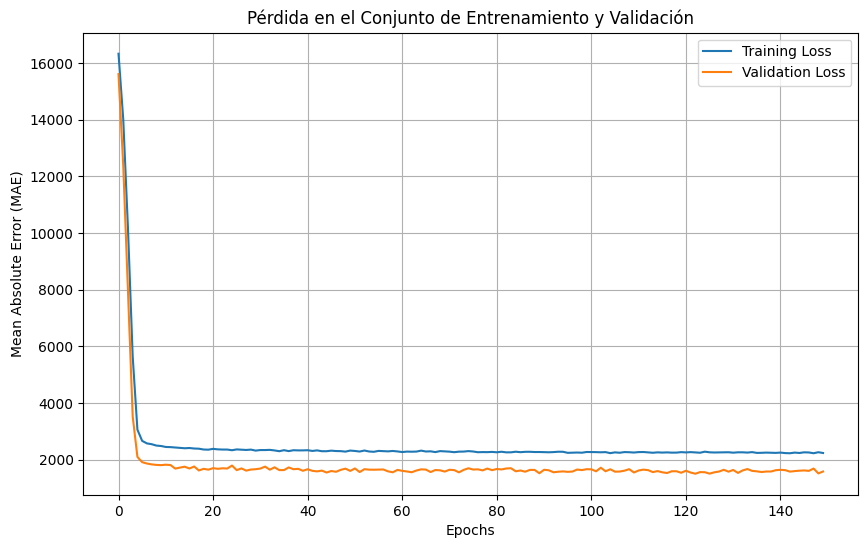

In [70]:
# Obtener la historia de la pérdida en el conjunto de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la pérdida en el conjunto de validación
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Pérdida en el Conjunto de Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()


In [71]:
df_results

,R^2,MSE,RMSE,MAE
Linear Regression,0.784993,2.090497e+07,4572.195259,2821.348333
Ridge Regression,0.784985,2.090576e+07,4572.281318,2821.215866
Lasso Regression,0.784980,2.090624e+07,4572.334024,2820.789518
Decision Tree Regressor,0.921130,7.668489e+06,2769.203763,1584.331054
Random Forest Regressor,0.951941,4.672742e+06,2161.652710,1276.254831
Gradient Boosting Regressor,0.900763,9.648721e+06,3106.239093,2040.107276
K-Neighbors Regressor,0.930252,6.781594e+06,2604.149449,1407.956870
Neural Network Regressor,0.884317,1.124778e+07,3353.771603,1962.546866
XGBoost,0.948769,4.981176e+06,2231.854937,1372.357573
Optimized XGBoost,0.957934,4.090046e+06,2022.386142,1213.318662


In [72]:
# Define los modelos optimizados con los mejores hiperparámetros
best_models = [
    ('Optimized DecisionTreeRegressor', DecisionTreeRegressor(max_depth=30,
                                                       min_samples_split=10,
                                                       min_samples_leaf=1)),
    ('Optimized RandomForestRegressor', RandomForestRegressor(max_depth= 30,
                                                      min_samples_leaf= 1,
                                                      min_samples_split= 5,
                                                      n_estimators= 300)),
    ('Optimized GradientBoostingRegressor', GradientBoostingRegressor(max_depth=8,
                                                              max_features= 'sqrt',
                                                              n_estimators=200,
                                                              learning_rate=0.1,  
                                                              subsample=0.9)),
    ('Optimized KNeighborsRegressor', KNeighborsRegressor(n_neighbors=7,
                                                weights='distance',
                                                algorithm='kd_tree',
                                                # p=grid_search_knn.best_params_['p']
                                                )),
    ('Optimized XGBoost', XGBRegressor(learning_rate=0.1, 
                                       max_depth=9, 
                                       n_estimators=300))
]

In [73]:
best_models.append(('Red Neuronal', model_dnn_modified))


In [74]:
# Combina tus modelos originales y los modelos optimizados
modelos = modelos + best_models
modelos

[('Linear Regression', LinearRegression()),
 ('Ridge Regression', Ridge()),
 ('Lasso Regression', Lasso()),
 ('Decision Tree Regressor', DecisionTreeRegressor()),
 ('Random Forest Regressor', RandomForestRegressor()),
 ('Gradient Boosting Regressor', GradientBoostingRegressor()),
 ('K-Neighbors Regressor', KNeighborsRegressor()),
 ('Neural Network Regressor', MLPRegressor()),
 ('XGBoost',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=na

In [75]:
df_results["MAE"].sort_values()

Optimized XGBoost                      1213.318662
Optimized RandomForestRegressor        1246.006073
Random Forest Regressor                1276.254831
Optimized GradientBoostingRegressor    1336.365973
Optimized KNeighborsRegressor          1371.939660
Red Neuronal                           1371.939660
XGBoost                                1372.357573
K-Neighbors Regressor                  1407.956870
Optimized DecisionTreeRegressor        1439.232768
Decision Tree Regressor                1584.331054
Neural Network Regressor               1962.546866
Gradient Boosting Regressor            2040.107276
Lasso Regression                       2820.789518
Ridge Regression                       2821.215866
Linear Regression                      2821.348333
Name: MAE, dtype: float64

In [76]:
# Crea y entrena el modelo de Regresión Lineal
modelo_linear = LinearRegression()
modelo_linear.fit(X_train, y_train)
with open('modelo_linear.pkl', 'wb') as archivo:
    pickle.dump(modelo_linear, archivo)

# Modelo Ridge Regression
modelo_ridge = Ridge(alpha=1.0)
modelo_ridge.fit(X_train, y_train)
with open('modelo_ridge.pkl', 'wb') as archivo:
    pickle.dump(modelo_ridge, archivo)

# Modelo Lasso Regression
modelo_lasso = Lasso(alpha=1.0)
modelo_lasso.fit(X_train, y_train)
with open('modelo_lasso.pkl', 'wb') as archivo:
    pickle.dump(modelo_lasso, archivo)

# Modelo Decision Tree Regressor
modelo_tree = DecisionTreeRegressor()
modelo_tree.fit(X_train, y_train)
with open('modelo_tree.pkl', 'wb') as archivo:
    pickle.dump(modelo_tree, archivo)

# Modelo Random Forest Regressor
modelo_forest = RandomForestRegressor()
modelo_forest.fit(X_train, y_train)
with open('modelo_forest.pkl', 'wb') as archivo:
    pickle.dump(modelo_forest, archivo)

# Modelo Gradient Boosting Regressor
modelo_gradient = GradientBoostingRegressor()
modelo_gradient.fit(X_train, y_train)
with open('modelo_gradient.pkl', 'wb') as archivo:
    pickle.dump(modelo_gradient, archivo)

# Modelo K-Neighbors Regressor
modelo_knn = KNeighborsRegressor()
modelo_knn.fit(X_train, y_train)
with open('modelo_knn.pkl', 'wb') as archivo:
    pickle.dump(modelo_knn, archivo)

# Modelo Neural Network Regressor
modelo_nn = MLPRegressor()
modelo_nn.fit(X_train, y_train)
with open('modelo_nn.pkl', 'wb') as archivo:
    pickle.dump(modelo_nn, archivo)

# Modelo XGBoost
modelo_xgb = XGBRegressor()
modelo_xgb.fit(X_train, y_train)
with open('modelo_xgb.pkl', 'wb') as archivo:
    pickle.dump(modelo_xgb, archivo)

# Modelo Optimizado Decision Tree Regressor
modelo_optimized_tree = DecisionTreeRegressor(max_depth=25, 
                                              min_samples_split=10,
                                              min_samples_leaf=1)
modelo_optimized_tree.fit(X_train, y_train)
with open('modelo_optimized_tree.pkl', 'wb') as archivo:
    pickle.dump(modelo_optimized_tree, archivo)

# Modelo Optimizado RandomForestRegressor
modelo_optimized_forest = RandomForestRegressor(max_depth= 20,
                                                min_samples_leaf= 1,
                                                min_samples_split= 5,
                                                n_estimators= 250)
modelo_optimized_forest.fit(X_train, y_train)
with open('modelo_optimized_forest.pkl', 'wb') as archivo:
    pickle.dump(modelo_optimized_forest, archivo)

# Modelo Optimizado GradientBoostingRegressor
modelo_optimized_gradient = GradientBoostingRegressor(max_depth=8,
                                                      max_features= 'sqrt',
                                                      n_estimators=200,
                                                      learning_rate=0.1,  
                                                      subsample=0.9)
modelo_optimized_gradient.fit(X_train, y_train)
with open('modelo_optimized_gradient.pkl', 'wb') as archivo:
    pickle.dump(modelo_optimized_gradient, archivo)

# Modelo Optimizado K-Neighbors Regressor
modelo_optimized_knn = KNeighborsRegressor(n_neighbors=7,
                                           weights='distance',
                                           algorithm='kd_tree',
                                        #    p=grid_search_knn.best_params_['p']
                                           )
modelo_optimized_knn.fit(X_train, y_train)
with open('modelo_optimized_knn.pkl', 'wb') as archivo:
    pickle.dump(modelo_optimized_knn, archivo)

modelo_optimized_xgb = XGBRegressor(n_estimators=300, 
                                    learning_rate=0.1, 
                                    max_depth=9)
modelo_optimized_xgb.fit(X_train, y_train)
with open('modelo_optimized_xgb.pkl', 'wb') as archivo:
    pickle.dump(modelo_optimized_xgb, archivo)

modelo_red_neuronal = ('Red Neuronal', model_dnn_modified)
archivo_pickle = 'modelo_red_neuronal.pkl'
with open(archivo_pickle, 'wb') as archivo:
    pickle.dump(modelo_red_neuronal, archivo)


print("Los modelos se han entrenado y guardado correctamente en archivos separados.")

C:\Users\Jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Los modelos se han entrenado y guardado correctamente en archivos separados.


# Cargamos el mejor modelo y lo enfrentamos.

In [77]:
# Cargar el modelo entrenado
modelo_xgb_path = 'modelo_optimized_xgb.pkl'
with open(modelo_xgb_path, 'rb') as archivo:
    modelo_xgb = pickle.load(archivo)

# Preparar los datos de validación
X_valid = valid_data.drop(['price', 'model'], axis=1)
y_valid = valid_data['price']

# Escalar los datos de validación de la misma manera que se escaló el conjunto de entrenamiento
X_valid_scaled = scaler.transform(X_valid)  

# Hacer predicciones en los datos de validación
y_pred_valid = modelo_xgb.predict(X_valid_scaled)

# Calcular métricas en los datos de validación
r2_val = r2_score(y_valid, y_pred_valid)
mse_val = mean_squared_error(y_valid, y_pred_valid)
rmse_val = mean_squared_error(y_valid, y_pred_valid, squared=False)
mae_val = mean_absolute_error(y_valid, y_pred_valid)

# Mostrar las métricas
print("Métricas en el conjunto de validación:")
print(f"R^2 en el conjunto de validación: {r2_val:.6f}")
print(f"MSE en el conjunto de validación: {mse_val:.6f}")
print(f"RMSE en el conjunto de validación: {rmse_val:.6f}")
print(f"MAE en el conjunto de validación: {mae_val:.6f}")


Métricas en el conjunto de validación:
R^2 en el conjunto de validación: 0.960273
MSE en el conjunto de validación: 3704119.598390
RMSE en el conjunto de validación: 1924.608947
MAE en el conjunto de validación: 1201.210311


### Predicciones real vs predicho

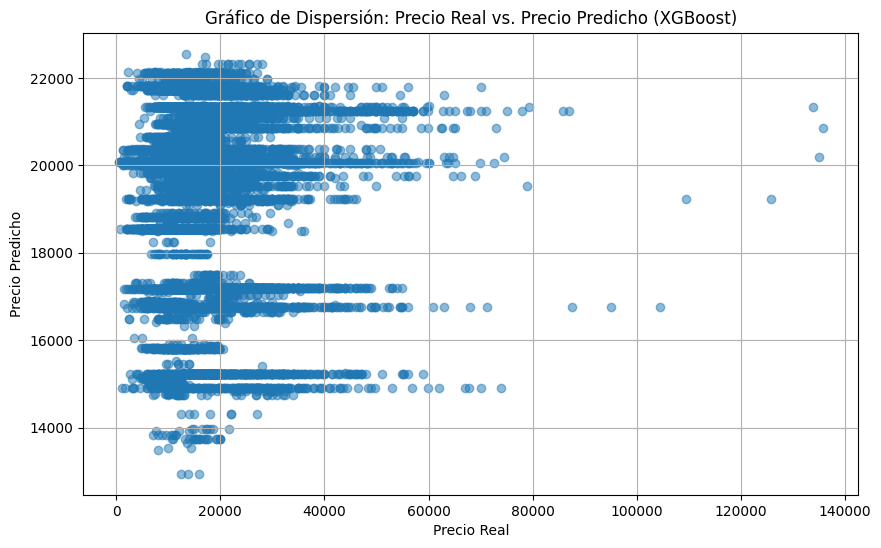

In [78]:
# Obtener las predicciones del modelo en el conjunto de validación
y_pred = modelo_optimized_xgb.predict(X_valid)

# Crear un gráfico de dispersión real vs. predicho
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Gráfico de Dispersión: Precio Real vs. Precio Predicho (XGBoost)")
plt.grid(True)
plt.show()

[0]	validation_0-mae:15098.43198	validation_0-rmse:17589.03679	validation_1-mae:15217.74400	validation_1-rmse:17639.33898
[1]	validation_0-mae:13595.61770	validation_0-rmse:15899.34841	validation_1-mae:13706.82103	validation_1-rmse:15948.47817


C:\Users\Jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:12242.55072	validation_0-rmse:14381.39234	validation_1-mae:12342.12000	validation_1-rmse:14422.43348
[3]	validation_0-mae:11024.90413	validation_0-rmse:13017.34840	validation_1-mae:11117.61070	validation_1-rmse:13057.20906
[4]	validation_0-mae:9928.66527	validation_0-rmse:11794.41848	validation_1-mae:10011.69101	validation_1-rmse:11828.90140
[5]	validation_0-mae:8941.78248	validation_0-rmse:10694.06437	validation_1-mae:9016.11080	validation_1-rmse:10724.00963
[6]	validation_0-mae:8053.61718	validation_0-rmse:9708.45995	validation_1-mae:8122.61724	validation_1-rmse:9737.22488
[7]	validation_0-mae:7254.11547	validation_0-rmse:8820.15680	validation_1-mae:7315.95830	validation_1-rmse:8845.98453
[8]	validation_0-mae:6534.67445	validation_0-rmse:8026.99162	validation_1-mae:6592.21543	validation_1-rmse:8053.17510
[9]	validation_0-mae:5888.01152	validation_0-rmse:7318.23247	validation_1-mae:5940.65385	validation_1-rmse:7343.29735
[10]	validation_0-mae:5307.77909	validation

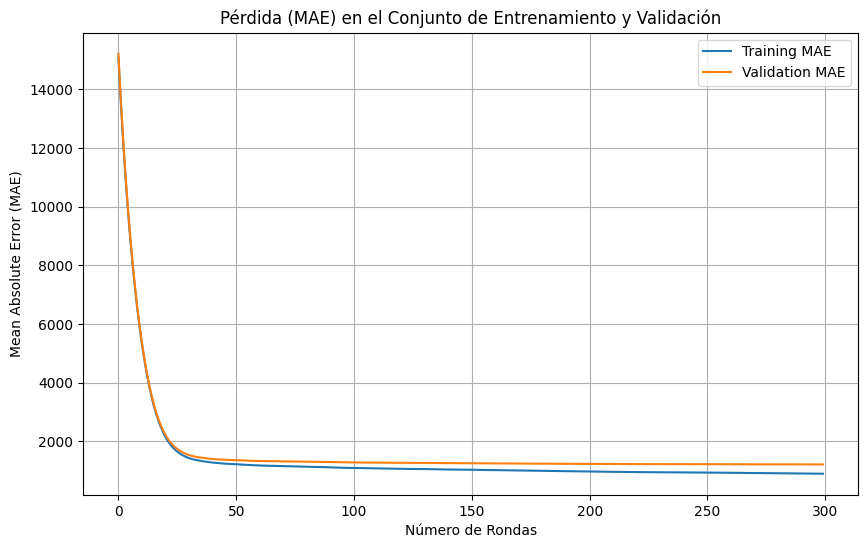

In [79]:
# Crear un modelo XGBoost con los parámetros del Grid Search
modelo_xgb = xgb.XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300)

# Entrenar el modelo con el conjunto de entrenamiento y habilitar early stopping con el conjunto de validación
evals = [(X_train, y_train), (X_val, y_val)]  

modelo_xgb.fit(
    X_train, y_train,
    eval_metric=["mae", "rmse"],  
    eval_set=evals,
    early_stopping_rounds=10,     
    verbose=True  
)

# Trazar la pérdida (MAE) en el conjunto de entrenamiento y validación
results = modelo_xgb.evals_result()
train_mae = results['validation_0']['mae']
val_mae = results['validation_1']['mae']

plt.figure(figsize=(10, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Número de Rondas')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Pérdida (MAE) en el Conjunto de Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
# Crear una copia del DataFrame de datos de validación
valid_data_with_predictions = valid_data.copy()

# Agregar las predicciones como una nueva columna en el DataFrame
valid_data_with_predictions['Predicciones'] = y_pred_valid

# Calcular el error absoluto entre las predicciones y los valores reales
valid_data_with_predictions['Error Absoluto'] = abs(valid_data_with_predictions['price'] - valid_data_with_predictions['Predicciones'])

# Ordenar el DataFrame por el error absoluto de manera descendente para ver los casos más extremos primero
valid_data_with_predictions = valid_data_with_predictions.sort_values(by='Error Absoluto', ascending=False)

# Mostrar los 10 casos más extremos
casos_extremos = valid_data_with_predictions.head(10)

casos_extremos


,model,year,price,mileage,tax,mpg,engineSize,Automatic,Manual,Semi-Auto,...,BMW,Ford,Hyundai,Mercedes,Skoda,Toyota,Vauxhall,volkwagen,Predicciones,Error Absoluto
10614,R8,2016,74500,28888,570,24.1,5200,True,False,False,...,False,False,False,False,False,False,False,False,37021.707031,37478.292969
44433,S Class,2018,104400,3796,145,31.7,4000,False,False,True,...,False,False,False,True,False,False,False,False,69480.890625,34919.109375
10593,R8,2019,135000,1000,145,32.8,5200,True,False,False,...,False,False,False,False,False,False,False,False,102379.148438,32620.851562
44832,G Class,2018,135771,19000,145,21.4,4000,False,False,True,...,False,False,False,True,False,False,False,False,112397.320312,23373.679688
1853,A6,2018,41500,17142,145,29.4,4000,False,False,True,...,False,False,False,False,False,False,False,False,64077.042969,22577.042969
53359,C Class,2020,61995,20,145,33.6,4000,True,False,False,...,False,False,False,True,False,False,False,False,84177.203125,22182.203125
97477,Caravelle,2019,55990,17600,145,33.6,2000,False,False,True,...,False,False,False,False,False,False,False,True,34865.808594,21124.191406
51717,C Class,2018,33690,12055,145,40.9,4000,False,False,True,...,False,False,False,True,False,False,False,False,54733.777344,21043.777344
45029,GLE Class,2018,55376,5234,145,23.9,5500,True,False,False,...,False,False,False,True,False,False,False,False,75495.101562,20119.101562
44547,S Class,1999,5995,34000,145,24.6,3200,True,False,False,...,False,False,False,True,False,False,False,False,23900.976562,17905.976562


In [81]:
# Obtener los 10 casos con los errores absolutos más bajos (las mejores predicciones)
casos_mejores = valid_data_with_predictions.tail(10)

# Imprimir los casos con los errores absolutos más bajos
casos_mejores


,model,year,price,mileage,tax,mpg,engineSize,Automatic,Manual,Semi-Auto,...,BMW,Ford,Hyundai,Mercedes,Skoda,Toyota,Vauxhall,volkwagen,Predicciones,Error Absoluto
52919,C Class,2019,30599,3601,145,44.1,2000,False,False,True,...,False,False,False,True,False,False,False,False,30598.011719,0.988281
94728,Tiguan,2018,19202,18904,150,46.3,1400,False,True,False,...,False,False,False,False,False,False,False,True,19201.039062,0.960938
61056,Kodiaq,2019,25999,7700,145,49.6,2000,False,False,True,...,False,False,False,False,True,False,False,False,25998.117188,0.882812
85688,Golf,2013,7790,57028,125,53.3,1400,False,True,False,...,False,False,False,False,False,False,False,True,7789.498047,0.501953
57468,Octavia,2019,18738,3461,145,45.6,1500,True,False,False,...,False,False,False,False,True,False,False,False,18738.447266,0.447266
77327,Mokka,2015,9998,19877,205,40.4,1400,True,False,False,...,False,False,False,False,False,False,True,False,9997.576172,0.423828
40015,Tucson,2019,15998,11751,145,34.9,1600,False,True,False,...,False,False,True,False,False,False,False,False,15998.354492,0.354492
26345,Fiesta,2013,7499,15546,0,76.4,1500,False,True,False,...,False,True,False,False,False,False,False,False,7499.258789,0.258789
89943,Passat,2020,30990,4765,145,48.7,2000,False,False,True,...,False,False,False,False,False,False,False,True,30989.867188,0.132812
84110,T-Roc,2019,32998,1566,150,32.5,2000,False,False,True,...,False,False,False,False,False,False,False,True,32997.960938,0.039062


In [88]:
subset_df = valid_data_with_predictions[["model", "price", "Predicciones", "Error Absoluto"]]
subset_df.sort_values(by="Error Absoluto", ascending=True).head(10)


,model,price,Predicciones,Error Absoluto
84110,T-Roc,32998,32997.960938,0.039062
89943,Passat,30990,30989.867188,0.132812
26345,Fiesta,7499,7499.258789,0.258789
40015,Tucson,15998,15998.354492,0.354492
77327,Mokka,9998,9997.576172,0.423828
57468,Octavia,18738,18738.447266,0.447266
85688,Golf,7790,7789.498047,0.501953
61056,Kodiaq,25999,25998.117188,0.882812
94728,Tiguan,19202,19201.039062,0.960938
52919,C Class,30599,30598.011719,0.988281
